# Predict tweets virality
#### Objective:  predict if a tweet will become viral the moment it was posted, using a combination of numerical categories, classes, and textual data.
#### Data: 81k tweets from twitter, with features of tweet content, author followers, author gender etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [14]:
tweets_df = pd.read_csv('tweets_df.csv')
tweets_df.head()

,published,url,content,lang,word_count,nsfw_level,sentiment,post_type,engagement,article_extended_attributes.twitter_impressions,article_extended_attributes.twitter_likes,article_extended_attributes.twitter_retweets,article_extended_attributes.twitter_quote_tweets,article_extended_attributes.twitter_replies,source_extended_attributes.twitter_followers,extra_author_attributes.world_data.country,extra_author_attributes.name,extra_author_attributes.gender,extra_author_attributes.description,docscore.ave
0,2023-10-07 08:22:09,http://twitter.com/Faytuks/status/171052590201...,IDF airstrikes in Gaza are underway. QT @idfon...,en,22,0,0,TEXT,264,0,214,49,1,0,127316,Norway,Faytuks News Δ,MALE,Fast & reliable news provider || Covering geop...,5092.64
1,2023-10-07 08:26:35,http://twitter.com/lookner/status/171052701555...,"""The Air Force is now attacking targets of the...",en,36,15,-5,TEXT,125,0,87,38,0,0,139780,United States,Steve Lookner,MALE,News Anchor & Founder of @AgendaFreeTV. Specia...,5591.20
2,2023-10-07 08:33:45,http://twitter.com/sentdefender/status/1710528...,"Israeli Minister of Defense, Yoav Gallant has ...",en,25,0,0,TEXT,853,0,682,153,18,0,514815,United States,OSINTdefender,UNKNOWN,Open Source Intelligence Monitor focused on Eu...,20592.60
3,2023-10-07 10:05:35,http://twitter.com/manniefabian/status/1710551...,"Defense Minister Yoav Gallant: ""Hamas made a g...",en,40,0,-5,TEXT,665,0,505,149,11,0,41279,Israel,Emanuel (Mannie) Fabian,MALE,@TimesOfIsrael military correspondent | @beng...,1651.16
4,2023-10-07 10:08:34,http://twitter.com/JoeTruzman/status/171055268...,Israeli Minister of Defense Yoav Gallant follo...,en,44,0,-5,VIDEO,8055,0,6345,1577,133,0,64779,United States,Joe Truzman,MALE,Research analyst focused on Palestinian armed ...,2591.16


# Feature Preparation
#### Convert categorical columns to one-hot encoding
#### Fill in textual columns with empty values with the word: missing

In [64]:
# Convert 'post_type' and 'extra_author_attributes.gender' to one-hot encoding
one_hot_encoded_post_type = pd.get_dummies(tweets_df['post_type'], prefix='post_type')
one_hot_encoded_gender = pd.get_dummies(tweets_df['extra_author_attributes.gender'], prefix='gender')

# Join the one-hot encoded columns back to the original DataFrame
tweets_df = pd.concat([tweets_df, one_hot_encoded_gender, one_hot_encoded_post_type], axis=1)

# fill empty text columns with the word: missing
tweets_df['content'] = tweets_df['content'].fillna('missing')
tweets_df['extra_author_attributes.description'] = tweets_df['extra_author_attributes.description'].fillna('missing')


# Data Cleaning
#### Remove rows where the number of engagement or impression is zero

In [23]:

num_zeros_impressions = (tweets_df['article_extended_attributes.twitter_impressions'] == 0).sum()
percent_zeros_impressions = (num_zeros_impressions / len(tweets_df)) * 100

num_zeros_engagement = (tweets_df['engagement'] == 0).sum()
percent_zeros_engagement = (num_zeros_engagement / len(tweets_df)) * 100

print(f"Percentage of zeros in impressions: {percent_zeros_impressions:.2f}%")
print(f"Percentage of zeros in engagement: {percent_zeros_engagement:.2f}%")

non_zero_filter = (tweets_df['article_extended_attributes.twitter_impressions'] != 0) & (tweets_df['engagement'] != 0)

# Apply the filter to the DataFrame to remove rows with zeros in either column
tweets_df_filtered = tweets_df[non_zero_filter]

print(f"\nNumber of rows before filtration: {len(tweets_df)}")
print(f"Number of rows before filtration: {len(tweets_df_filtered)}")


Percentage of zeros in impressions: 6.12%
Percentage of zeros in engagement: 4.62%

Number of rows before filtration: 81313
Number of rows before filtration: 76078


# Predicted Value Engineering
#### A binary value of tweet virality based on being on top 10 percentage of tweets in engagement

#### Other options: 
* Regression
 * Combination of impression as engagement for virality score

In [24]:
threshold = tweets_df_filtered['engagement'].quantile(0.90)  # top 10%
tweets_df_filtered.loc[:, 'is_viral'] = tweets_df_filtered['engagement'] >= threshold

print(f"The threshold for virality is if a tweet has more than {int(threshold)} engagement")


The threshold for virality is if a tweet has more than 11303 engagement


C:\Users\user\AppData\Local\Temp\ipykernel_13684\740651180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df_filtered.loc[:, 'is_viral'] = tweets_df_filtered['engagement'] >= threshold


### Categorizing features: textual, numerical, categorical

In [25]:
col_info = {}

col_info['text_cols'] = [
    'content',
    'extra_author_attributes.description'
]

col_info['num_cols'] = [
    'word_count',
    'nsfw_level',
    'sentiment',
    'source_extended_attributes.twitter_followers'
]

col_info['cat_cols'] = [
    'gender_FEMALE',
    'gender_MALE',
    'gender_UNKNOWN',
    'post_type_IMAGE',
    'post_type_LINK',
    'post_type_TEXT',
    'post_type_VIDEO'
]

col_info['label_col'] = 'is_viral'
col_info['label_list'] = [0, 1]



In [42]:
from sklearn.model_selection import train_test_split

# Prepare features and target
X = tweets_df_filtered.drop(['is_viral'], axis=1)
y = tweets_df_filtered['is_viral']

# Splitting the data into training, validation, and test sets
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_, X_test_part, y_val, y_test_part = train_test_split(X_test_full, y_test, test_size=0.5, random_state=42)

# for LR and xgboost
X_train = X_train_full[col_info['num_cols'] + col_info['cat_cols']]
X_test = X_test_part[col_info['num_cols'] + col_info['cat_cols']]
X_val = X_val_[col_info['num_cols'] + col_info['cat_cols']]

# for catboost
X_train_catboost = X_train_full[col_info['num_cols'] + col_info['cat_cols'] + col_info['text_cols']]
X_test_catboost = X_test_part[col_info['num_cols'] + col_info['cat_cols'] + col_info['text_cols']]
X_val_catboost = X_val_[col_info['num_cols'] + col_info['cat_cols'] + col_info['text_cols']]


## Hyperparameter tuning using Optuna

## For CATboost

In [17]:
import optuna
import catboost as cb

def objective(trial):
    # Hyperparameters to tune
    params = {
        "iterations": trial.suggest_int("iterations", 50, 200),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', None])

    }

    # Create a Pool with categorical features
    train_pool = cb.Pool(X_train_catboost, y_train, text_features=col_info['text_cols'],
                         cat_features=col_info['cat_cols'],
                         )
    val_pool = cb.Pool(X_val_catboost, y_val, text_features=col_info['text_cols'],
                       cat_features=col_info['cat_cols'],
                       )


    model = cb.CatBoostClassifier(**params, verbose=False, eval_metric='AUC')
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)
    best_scores = model.get_best_score()
    
    if 'validation' in best_scores and 'AUC' in best_scores['validation']:
        auc = best_scores['validation']['AUC']
    else:
        raise ValueError("AUC not found in model evaluation scores")
    return auc



In [232]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best trial:', study.best_trial.params)

[I 2024-04-25 10:03:34,668] A new study created in memory with name: no-name-bca21c87-b5e6-435c-9d91-a4ab42ede834
[I 2024-04-25 10:04:21,265] Trial 0 finished with value: 0.7921181480116841 and parameters: {'iterations': 168, 'learning_rate': 0.028608246761699953, 'depth': 7, 'l2_leaf_reg': 0.0018037693347956636, 'bootstrap_type': 'Bayesian', 'random_strength': 3.4258060884087255e-07, 'bagging_temperature': 2.598200797485518, 'od_type': 'Iter', 'od_wait': 21, 'auto_class_weights': None}. Best is trial 0 with value: 0.7921181480116841.
[I 2024-04-25 10:06:05,190] Trial 1 finished with value: 0.7902709457842538 and parameters: {'iterations': 171, 'learning_rate': 0.002145913168481236, 'depth': 9, 'l2_leaf_reg': 9.83312429607392e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.1588497193357662, 'bagging_temperature': 0.06397589213325894, 'od_type': 'Iter', 'od_wait': 34, 'auto_class_weights': None}. Best is trial 0 with value: 0.7921181480116841.
[I 2024-04-25 10:06:36,348] Trial 2

Best trial: {'iterations': 175, 'learning_rate': 0.05721444008924833, 'depth': 7, 'l2_leaf_reg': 0.946509297715659, 'bootstrap_type': 'Bayesian', 'random_strength': 1.264189996331671e-05, 'bagging_temperature': 0.9294362936515296, 'od_type': 'Iter', 'od_wait': 15, 'auto_class_weights': 'Balanced'}


## For XGBoost

In [43]:
from sklearn.metrics import roc_auc_score

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    
    model = XGBClassifier(**param, use_label_encoder=False)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=30,
        verbose=False
    )
    
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    
    return auc

In [44]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best trial:', study.best_trial.params)

[I 2024-05-28 19:48:34,313] A new study created in memory with name: no-name-c1a8abae-6fdc-415d-8489-4f0c219fcb4a


ERROR! Session/line number was not unique in database. History logging moved to new session 240


C:\Users\user\AppData\Local\Temp\ipykernel_13684\999994991.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_13684\999994991.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_13684\999994991.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
C:\Users\user\AppData\Local\T

Number of finished trials:  50
Best trial:
  Value: 0.7388907670276492
  Params: 
    booster: dart
    lambda: 1.4754166505028554e-08
    alpha: 2.5136455258765763e-07
    subsample: 0.9305173606717969
    colsample_bytree: 0.8127268298699941
    max_depth: 9
    eta: 0.011514718551378108
    n_estimators: 336
{'booster': 'dart', 'lambda': 1.4754166505028554e-08, 'alpha': 2.5136455258765763e-07, 'subsample': 0.9305173606717969, 'colsample_bytree': 0.8127268298699941, 'max_depth': 9, 'eta': 0.011514718551378108, 'n_estimators': 336}


# We use three models for this classification problem:
Logistic regression
XGboost
CATboost

In [45]:
best_params_cat = {'iterations': 175, 'learning_rate': 0.05721444008924833, 'depth': 7, 'l2_leaf_reg': 0.946509297715659, 'bootstrap_type': 'Bayesian', 'random_strength': 1.264189996331671e-05, 'bagging_temperature': 0.9294362936515296, 'od_type': 'Iter', 'od_wait': 15, 'auto_class_weights': 'Balanced'}
best_params_xgb = {'booster': 'dart', 'lambda': 1.4754166505028554e-08, 'alpha': 2.5136455258765763e-07, 'subsample': 0.9305173606717969, 'colsample_bytree': 0.8127268298699941, 'max_depth': 9, 'eta': 0.011514718551378108, 'n_estimators': 336}

# Logistic Regression with class weight
log_reg = LogisticRegression(class_weight='balanced')

# XGBoost with scale_pos_weight
xgb_model = XGBClassifier(**best_params_xgb,
                        use_label_encoder=False,
                          eval_metric='logloss')
                          # scale_pos_weight=9)  # Assuming 10% positives, 90% negatives

catboost_model = CatBoostClassifier(
    **best_params_cat,
    text_features=col_info['text_cols'],
    cat_features=col_info['cat_cols'],
    eval_metric='AUC')



In [48]:
# Train Logistic Regression
log_reg.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30, verbose=False)


# Create Pool objects for train and validation sets
train_pool = cb.Pool(X_train_catboost, y_train, text_features=col_info['text_cols'],
                     cat_features=col_info['cat_cols']
                     )
val_pool = cb.Pool(X_val_catboost, y_val, text_features=col_info['text_cols'],
                   cat_features=col_info['cat_cols']
                   )

# Train model with cross-validation and plot
cv_results = catboost_model.fit(train_pool, eval_set=val_pool, plot=True)



c:\users\user\desktop\job hunt\github\llm_workshop\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7802811	best: 0.7802811 (0)	total: 543ms	remaining: 1m 34s
1:	test: 0.7928973	best: 0.7928973 (1)	total: 1.14s	remaining: 1m 38s
2:	test: 0.7944750	best: 0.7944750 (2)	total: 1.73s	remaining: 1m 39s
3:	test: 0.7961427	best: 0.7961427 (3)	total: 2.34s	remaining: 1m 40s
4:	test: 0.7964478	best: 0.7964478 (4)	total: 3.05s	remaining: 1m 43s
5:	test: 0.7987255	best: 0.7987255 (5)	total: 3.65s	remaining: 1m 42s
6:	test: 0.7984884	best: 0.7987255 (5)	total: 4.25s	remaining: 1m 41s
7:	test: 0.7991203	best: 0.7991203 (7)	total: 4.87s	remaining: 1m 41s
8:	test: 0.8003381	best: 0.8003381 (8)	total: 5.49s	remaining: 1m 41s
9:	test: 0.8018269	best: 0.8018269 (9)	total: 6.08s	remaining: 1m 40s
10:	test: 0.8023583	best: 0.8023583 (10)	total: 6.76s	remaining: 1m 40s
11:	test: 0.8034968	best: 0.8034968 (11)	total: 7.38s	remaining: 1m 40s
12:	test: 0.8041873	best: 0.8041873 (12)	total: 7.96s	remaining: 1m 39s
13:	test: 0.8042075	best: 0.8042075 (13)	total: 8.51s	remaining: 1m 37s
14:	test: 0.

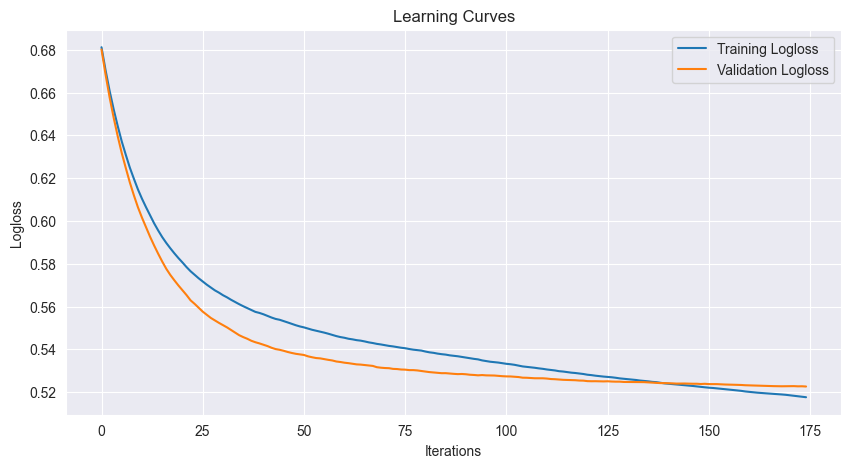

In [49]:
# Accessing the training and validation scores from model
train_auc = catboost_model.get_evals_result()['learn']['Logloss']
val_auc = catboost_model.get_evals_result()['validation']['Logloss']

# Plotting learning curves
iterations = range(len(train_auc))
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_auc, label='Training Logloss')
plt.plot(iterations, val_auc, label='Validation Logloss')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Make prediction on test set using the three models

In [55]:
# Predictions
y_pred_log = log_reg.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

test_pool = cb.Pool(X_test_catboost, y_test_part, text_features=col_info['text_cols'],
                   cat_features=col_info['cat_cols']
                   )
y_pred_catboost = catboost_model.predict(test_pool)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test_part, y_pred_log))
# print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("XGBoost Accuracy:", accuracy_score(y_test_part, y_pred_xgb))
print("Catboost Accuracy:", accuracy_score(y_test_part, y_pred_catboost))


Logistic Regression Accuracy: 0.10160357518401683
XGBoost Accuracy: 0.9068086225026288
Catboost Accuracy: 0.7534174553101998


### Accuracy seems to be the best with the XGBoost, but lets delve into other metrics

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Evaluate each model
def evaluate_model(y_test, y_pred):
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))


# Logistic Regression Performance
print("Logistic Regression Performance:")
evaluate_model(y_test_part, log_reg.predict(X_test))

# XGBoost Performance
print("\nXGBoost Performance:")
evaluate_model(y_test_part, xgb_model.predict(X_test))

# Catboost Performance
print("\nCatboost Performance:")
evaluate_model(y_test_part, catboost_model.predict(X_test_catboost))


Logistic Regression Performance:
Precision: 0.10113098369279326
Recall: 1.0
F1 Score: 0.18368565627612565

XGBoost Performance:
Precision: 0.7142857142857143
Recall: 0.13003901170351106
F1 Score: 0.22002200220022003

Catboost Performance:
Precision: 0.2545454545454545
Recall: 0.7464239271781534
F1 Score: 0.3796296296296296


# Conclusions so far:
* Logistic regression is a too simplistic model for the problem, even with weighted classes the f1-score is very low
* When looking at F1-score, CATboost has better performance then XGBosst

# Following evaluation methods:
* confusion matrix
* precision-recall plot
* ROC plot


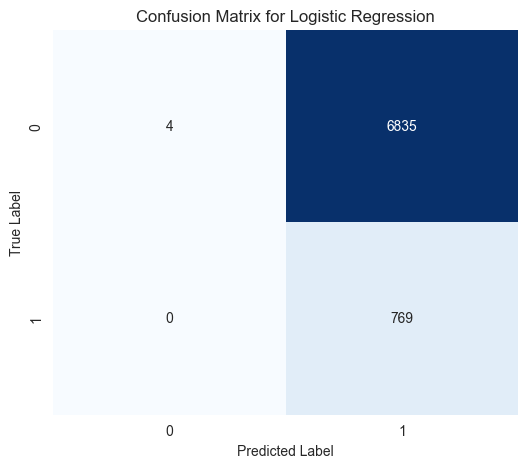

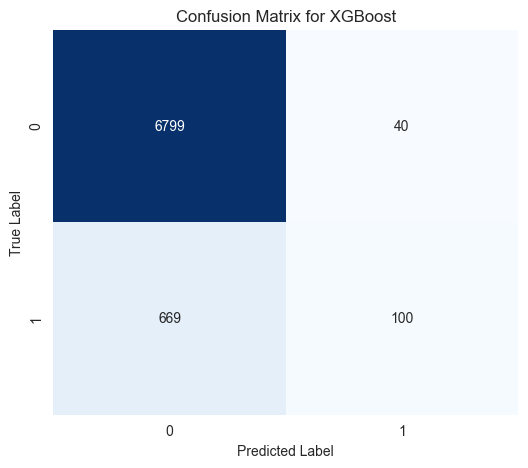

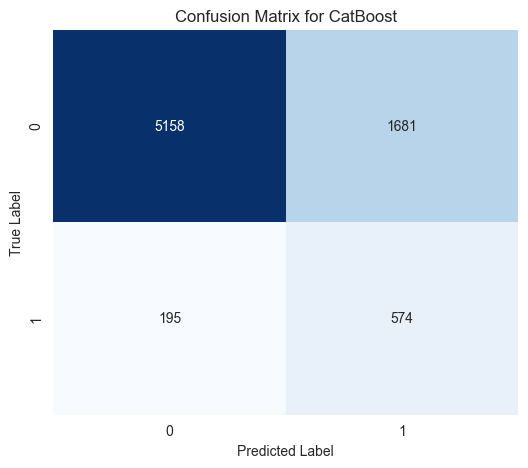

In [60]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_log = confusion_matrix(y_test_part, y_pred_log)
# cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_xgb = confusion_matrix(y_test_part, y_pred_xgb)
cm_ctb = confusion_matrix(y_test_part, y_pred_catboost)


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


# Plotting each confusion matrix
plot_confusion_matrix(cm_log, 'Logistic Regression')
# plot_confusion_matrix(cm_svm, 'SVM')
plot_confusion_matrix(cm_xgb, 'XGBoost')
plot_confusion_matrix(cm_ctb, 'CatBoost')


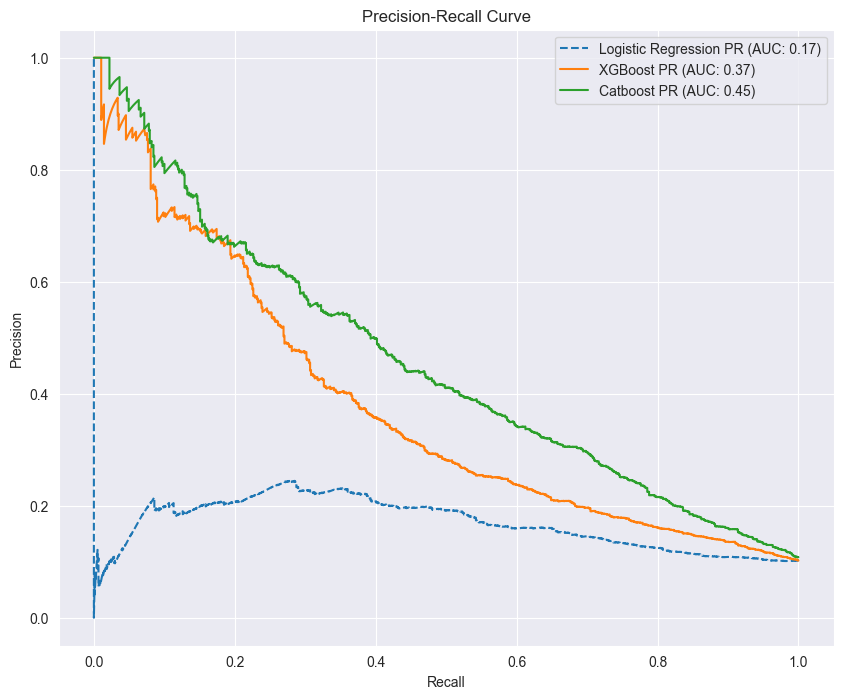

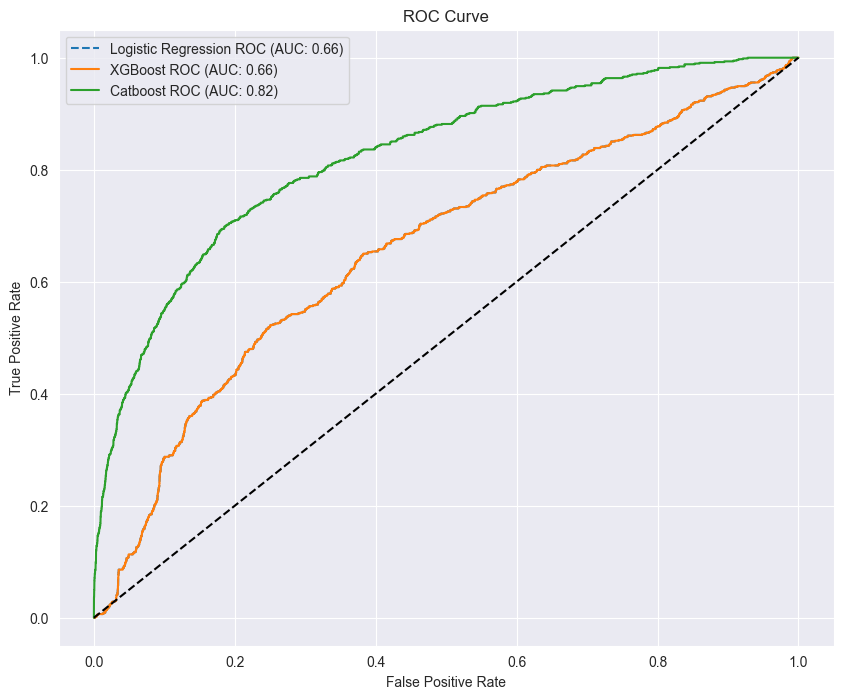

In [66]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Get probability scores for Logistic Regression
y_scores_log = log_reg.predict_proba(X_test)[:, 1]

# Get probability scores for XGBoost
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Get probability scores for CatBoost
y_scores_ctb = catboost_model.predict_proba(X_test_catboost)[:, 1]

# Calculate precision-recall for each model
precision_log, recall_log, thresholds_log = precision_recall_curve(y_test_part, y_scores_log)
fpr_log, tpr_log, _ = roc_curve(y_test_part, y_scores_log)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test_part, y_scores_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_part, y_scores_log)
precision_ctb, recall_ctb, thresholds_ctb = precision_recall_curve(y_test_part, y_scores_ctb)
fpr_ctb, tpr_ctb, _ = roc_curve(y_test_part, y_scores_ctb)

# Calculate AUC for each curve
auc_pr_log = auc(recall_log, precision_log)
auc_roc_log = auc(fpr_log, tpr_log)

auc_pr_xgb = auc(recall_xgb, precision_xgb)
auc_roc_xgb = auc(fpr_xgb, tpr_xgb)

auc_pr_ctb = auc(recall_ctb, precision_ctb)
auc_roc_ctb = auc(fpr_ctb, tpr_ctb)

# Create a plot for the precision-recall curves
plt.figure(figsize=(10, 8))

# Plot each model's precision-recall curve
plt.plot(recall_log, precision_log, label=f'Logistic Regression PR (AUC: {auc_pr_log:.2f})', linestyle='--')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost PR (AUC: {auc_pr_xgb:.2f})', linestyle='-')
plt.plot(recall_ctb, precision_ctb, label=f'Catboost PR (AUC: {auc_pr_ctb:.2f})', linestyle='-')

# Labeling the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Create a plot for the ROC curves
plt.figure(figsize=(10, 8))

# Plot each model's ROC curve
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression ROC (AUC: {auc_roc_log:.2f})', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ROC (AUC: {auc_roc_xgb:.2f})', linestyle='-')
plt.plot(fpr_ctb, tpr_ctb, label=f'Catboost ROC (AUC: {auc_roc_ctb:.2f})', linestyle='-')

# Labeling the plot
plt.plot([0, 1], [0, 1], 'k--')  # Draw the diagonal line for no-skill classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
df_xgb = pd.DataFrame({
    'Recall': recall_ctb[:-1],  # Drop the last element to match the thresholds' shape
    'Precision': precision_ctb[:-1],  # Drop the last element to match the thresholds' shape
    'Thresholds': thresholds_ctb
})

## Take a look at the tweets the catboost model predicted as the most viral

In [38]:
# Assuming xgb_model is your trained XGBoost classifier and X_test contains the features from tweets_df_filtered
X_test_part['probability'] = catboost_model.predict_proba(X_test_part[col_info['num_cols'] + col_info['cat_cols'] + col_info['text_cols']])[:, 1]
high_prob_df = X_test_part[X_test_part['probability'] >= 0.80]
high_prob_df.head(n=20)

,published,url,content,lang,word_count,nsfw_level,sentiment,post_type,engagement,article_extended_attributes.twitter_impressions,...,extra_author_attributes.description,docscore.ave,gender_FEMALE,gender_MALE,gender_UNKNOWN,post_type_IMAGE,post_type_LINK,post_type_TEXT,post_type_VIDEO,probability
25416,2023-11-27 19:57:29,http://twitter.com/jacksonhinklle/status/17291...,🚨🇵🇸 #ElonGoToGaza is TRENDING! Make a post and...,en,17,0,0,IMAGE,21543,336479,...,Help me expose the propagandists by subscribin...,90819.24,False,True,False,True,False,False,False,0.951408
12782,2023-11-20 16:51:03,http://twitter.com/TheMossadIL/status/17266141...,The Palestinian Ministry of Justice in Gaza Ho...,en,14,0,0,IMAGE,19283,417539,...,For the duration of Swords of Iron to defeat H...,21384.32,False,True,False,True,False,False,False,0.843312
73865,2024-02-12 03:58:27,http://twitter.com/caitoz/status/1756860286219...,Israel Weaponizes Sympathy And Victimhood Ther...,en,43,0,-5,TEXT,4546,143370,...,100% reader-funded writer. All works free to r...,14545.80,True,False,False,False,False,True,False,0.834349
13059,2023-11-20 18:24:57,http://twitter.com/DrEliDavid/status/172663776...,“Palestine” 🇵🇸 is the only country in the worl...,en,46,0,0,IMAGE,13019,3408812,...,"Researcher, Lecturer, Entrepreneur & Investor ...",21275.08,True,False,False,True,False,False,False,0.889745
77061,2024-02-26 09:23:10,http://twitter.com/visegrad24/status/176201543...,Anti-Israel activists masked up and vandalize ...,en,35,0,-5,VIDEO,12485,466959,...,"Aggregating and curating news, politics and cu...",37377.00,False,False,True,False,False,False,True,0.843129
46509,2023-12-19 19:47:23,http://twitter.com/jacksonhinklle/status/17371...,💔🇵🇸 Pray for Gaza https://t.co/O4es6gFeDz,en,4,0,0,VIDEO,95105,1121785,...,Help me expose the propagandists by subscribin...,95519.36,False,True,False,False,False,False,True,0.952390
21544,2023-11-24 21:15:49,http://twitter.com/missfalsteenia/status/17281...,a fetus was burned in his mothers womb. a fetu...,en,43,1,-5,TEXT,67309,681322,...,I talk about Palestine 🍉🫒,1871.88,True,False,False,False,False,True,False,0.841439
44113,2023-12-16 01:41:08,http://twitter.com/kthalps/status/173580723099...,Israel has no choice but to… use human shields...,en,25,0,-5,TEXT,10760,166792,...,"A Jew for a #Ceasefirenow, Host, Katie Halper ...",7480.40,True,False,False,False,False,True,False,0.803071
48905,2023-12-23 18:50:29,http://twitter.com/sahouraxo/status/1738602991...,BREAKING: An Israeli occupation army sniper ki...,en,40,0,-5,IMAGE,3137,43862,...,Independent Lebanese geopolitical commentator.,22204.96,True,False,False,True,False,False,False,0.866682
65797,2024-01-15 19:00:18,http://twitter.com/MuellerSheWrote/status/1746...,"If you sit this election out, I can 100% guara...",en,45,0,-5,TEXT,15383,394114,...,FOLLOW ME ON POST: https://post.news/@/Mueller...,29446.36,True,False,False,False,False,True,False,0.858433


## Feature importance
#### Identify the most important features that hold information for the classification using 2 methods

Text(0.5, 1.0, 'Feature Importance')

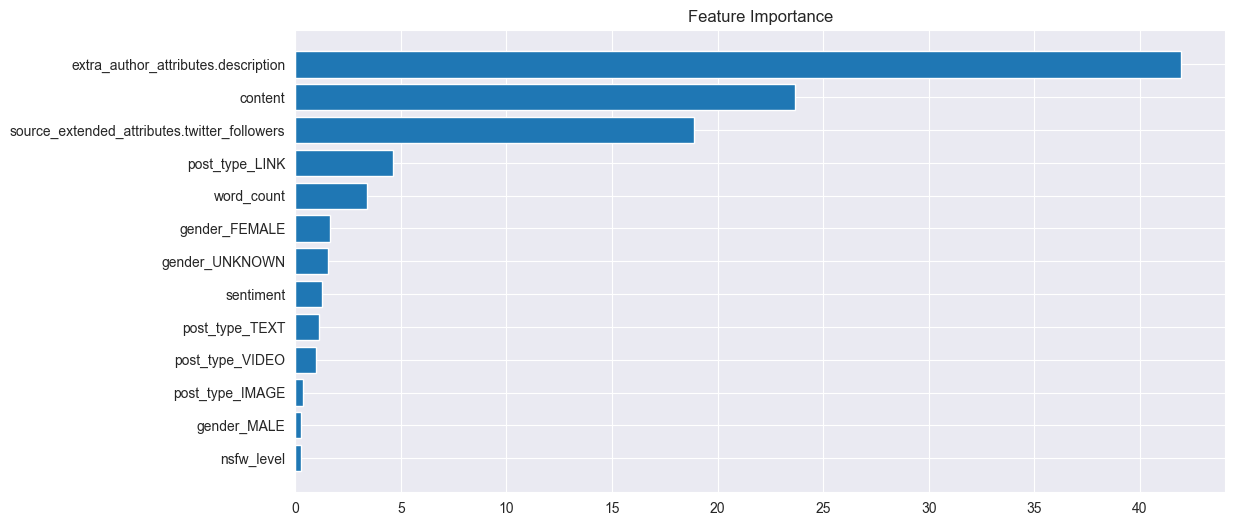

In [39]:
model = catboost_model
data = X_test_catboost

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(data.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'SHAP Importance')

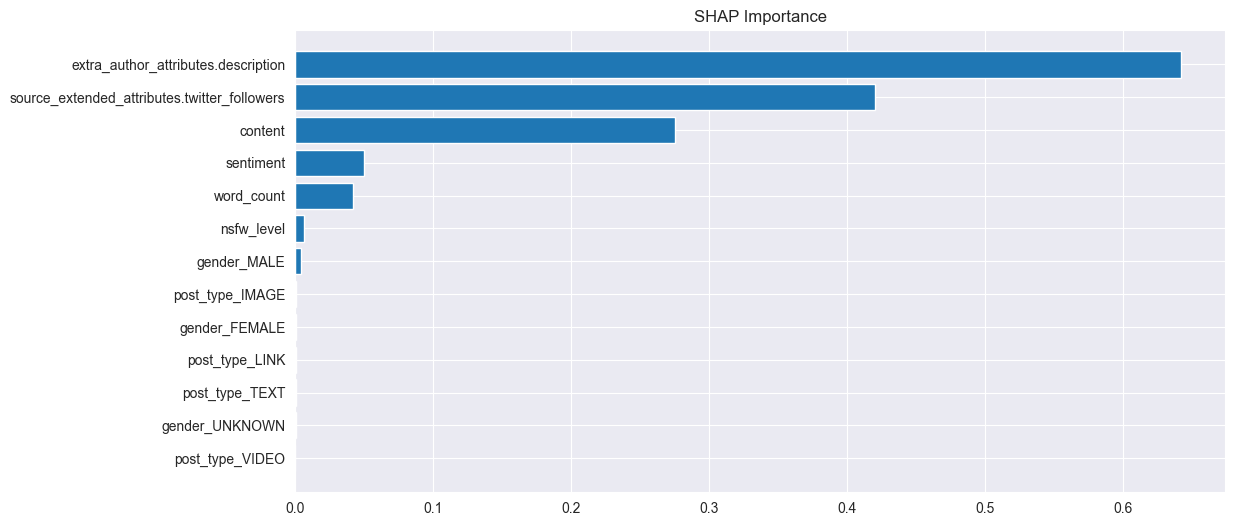

In [41]:

test_pool = Pool(data=X_test_catboost, label=y_test_part, text_features=col_info['text_cols'],
                 cat_features=col_info['cat_cols'],
                 )

model = catboost_model
data = test_pool

explainer = shap.Explainer(model)

shap_values = explainer(data)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_catboost.columns)[sorted_idx])
plt.title('SHAP Importance')

## Conclusion
### The obtained results were not good - F1-score of 0.37 for Catboost is rather poor.
### One possibility is that the data is not good enough. Another is that the model is not complex enough to catch 
### the relation between the predicted value and the features. Let's try a different approach, this time with LLM